# Predicting Airbnb Prices Across European Cities

In this project, we aim to predict Airbnb prices across major European cities using different factors that can impact price fluctuations.

## Dataset Description

***Kaggle Link:*** https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data?select=london_weekdays.csv

***Weekend Column:***  1 if its a weekend and 0 if it is not

***Host_is_superhost:***  if a host is a superhost, they meet these requirements (source: https://www.airbnb.com/help/article/829) :

- Hosted at least 10 reservations, or 3 reservations that total at least 100 nights
- Maintained a 90% or higher response rate
- Maintained a less than 1% cancellation rate, with exceptions for cancellations due to Major Disruptive Events or other valid reasons
- Maintained a 4.8 or higher overall rating (A review counts towards Superhost status when either both the guest and the host have submitted a review, or the 14-day window for reviews is over, whichever comes first.)

***Bedrooms Column:***  in the case that bedrooms = 0, it might be because the listing is for a studio

***Multiple_room Column:***  1 if listing is for multiple rooms, 0 otherwise.

***Spare_room Column:***  if a listing is NOT for multiple rooms and is NOT for business purpose, then the listing is only for one room

***Business_purpose Column:***  1 if it is for business purpose (full time income generating) or not (personal use, for example renting out a spare room for a few weeks). For this classification, we assume that business listings typically feature more rooms than the threshold for multiple rooms column. This is because we noticed that there are listings that are NOT multiple rooms and NOT for business purpose.

***Log_price Column:***  we took the natural log of the price because we noticed that the price is very skewed.

In [4]:
# Data Preprocessing
import pandas as pd
import numpy as np
import zipfile
import os

# Exploratory Data Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Principal Component Analysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import decomposition

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

Let's preprocess the datasets in *Airbnb_data.zip* to understand the features and how to proceed with Exploratory Data Analysis (EDA).

First, let's extract and load each of the airbnb datasets from the *Airbnb_data.zip*.

In [5]:
# # Load Dataset - COLAB
# from google.colab import files
# uploaded = files.upload()
# !unzip Airbnb_data.zip

# datasets = {}
# for _, _, filenames in os.walk("Airbnb_data"):
#   for file_name in filenames:
#     name = file_name.split(".")[0]
#     datasets[name] = pd.read_csv("Airbnb_data/" + file_name)
# datasets

In [6]:
# Load Dataset - VSCode
path = "Airbnb_data.zip"
folder = "Airbnb_data"

# extract zipfile
with zipfile.ZipFile(path, "r") as zip_ref:
    zip_ref.extractall(folder)

# list extracted files
files = os.listdir(folder)
print(f"Extracted Files: {files}\n")

# load csv files
datasets = {}

for file in files:
    if file.endswith(".csv"):
        print(f"Loading file: {file}")
        path = os.path.join(folder, file)
        df = pd.read_csv(path)
        datasets[file] = df

Extracted Files: ['amsterdam_weekdays.csv', 'barcelona_weekends.csv', 'Airbnb_data', 'rome_weekdays.csv', 'berlin_weekdays.csv', 'budapest_weekdays.csv', 'vienna_weekdays.csv', 'london_weekdays.csv', 'lisbon_weekends.csv', 'athens_weekends.csv', 'paris_weekends.csv', 'barcelona_weekdays.csv', '__MACOSX', 'berlin_weekends.csv', 'rome_weekends.csv', 'amsterdam_weekends.csv', 'athens_weekdays.csv', 'paris_weekdays.csv', 'vienna_weekends.csv', 'budapest_weekends.csv', 'lisbon_weekdays.csv', 'london_weekends.csv']

Loading file: amsterdam_weekdays.csv
Loading file: barcelona_weekends.csv
Loading file: rome_weekdays.csv
Loading file: berlin_weekdays.csv
Loading file: budapest_weekdays.csv
Loading file: vienna_weekdays.csv
Loading file: london_weekdays.csv
Loading file: lisbon_weekends.csv
Loading file: athens_weekends.csv
Loading file: paris_weekends.csv
Loading file: barcelona_weekdays.csv
Loading file: berlin_weekends.csv
Loading file: rome_weekends.csv
Loading file: amsterdam_weekends.csv

Now that we've loaded the airbnb datasets, we can continue with data preprocessing to prepare it for EDA.
1. ***Add Columns:*** Create *city* and *weekend* columns for each dataset
2. ***Combine Datasets:*** Combine all datasets
3. ***Handle Nulls:*** Handle missing and irrelevant data

### i) Add Columns

First, let's create *city* and *weekend* columns for each dataset.

In [7]:
# Add "city" & "weekend" Columns
for name, dataset in datasets.items():
    city, weekend = name.split("_")
    dataset["city"] = city
    dataset["weekend"] = weekend == "weekends"
    dataset["weekend"] = dataset["weekend"].astype(int)

### ii) Combine Datasets

Second, let's combine all of the datasets into one airbnb dataset. This will allow us to compare common features more easily and perform a more cohesive analysis.

In [8]:
# Combine Datasets
df = pd.concat([datasets[file_name] for file_name in datasets])
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


***Observation:*** Based on the concatenated airbnb dataset, we see that the *unnamed* column is simply the index from the original dataset. We don't need this anymore...

### iii) Clean Data

Let's clean our new dataset by handling the inconsistent and missing data.

First, let's standardize the column names for better readability and consistency.

In [9]:
# Standardize Column Names
name = {'realSum' :'price',
        'biz': 'business_purpose',
        'multi' : 'multiple_rooms',
        'dist' : 'dist_city_center',
        'metro_dist' : 'dist_metro_station',
        'lng' : 'longitude',
        'lat':'latitude'
        }

df = df.rename(columns = name)
df.head()

,Unnamed: 0,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,...,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


***Observation:*** The *Unnamed* column is redundant and unecessary as it's the same as the original dataset's indices.

So let's drop *Unnamed* from the dataset.

In [10]:
# Drop "Unnamed" Column
df = df.drop(columns =['Unnamed: 0'])
df.head()

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,...,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


Now let's look at the descriptive statistics of our new dataset. This will give us insight into skewness and outliers in the dataset that we will need to handle.

In [11]:
# Descriptive Statistics
df.describe()

,price,person_capacity,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,weekend
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.0
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128,0.0
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263,0.0
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,0.0
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510,0.0
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690,0.0
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885,0.0
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410,0.0


***Observation:*** Based on the descriptive statistics, *price* is heavily skewed.

Let's use log to transform the *price* column so it's standardized.

In [12]:
# Standardize "price" Column
df["price"] = np.log(df['price'])
df.describe()

,price,person_capacity,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,weekend
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.0
mean,5.419519,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128,0.0
std,0.596600,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263,0.0
min,3.549024,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,0.0
25%,5.002282,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510,0.0
50%,5.353483,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690,0.0
75%,5.767365,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885,0.0
max,9.827980,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410,0.0


Let's add a *spare_room* column to the dataset based on the *multiple_rooms* and *business_purpose* columns.

This will add more insight into the types of listings users are booking.

In [13]:
# Add "spare_room" Column
df['spare_room'] = ((df['multiple_rooms'] == 0) & (df['business_purpose'] == 0))
df.head()

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,...,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend,spare_room
0,5.268032,Private room,False,True,2.0,False,1,0,10.0,93.0,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0,False
1,5.841356,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0,True
2,5.576333,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0,False
3,6.071960,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0,False
4,6.185288,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0,True


Now that we handled inconsistent data, we can handle missing data.

Let's see if and where our dataset has missing values so we can determine whether to drop or imputate it.

In [14]:
# Check Missing Data
np.sum(df.isnull(), axis = 0)

price                         0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multiple_rooms                0
business_purpose              0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist_city_center              0
dist_metro_station            0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
longitude                     0
latitude                      0
city                          0
weekend                       0
spare_room                    0
dtype: int64

***Observation:*** Our dataset has no null values! So there's no need to handle missing data and we can continue with our EDA.

## Exploratory Data Analysis (EDA)

Next, let's take an initial look at the features in our dataset, so we can gain more insight about their roles and characteristics.

### i) Feature Distributions

First, let's plot the feature distributions for each variable in the dataset.

In [15]:
# Graph Functions
def init_subplots(rows, cols, figsize, df):
    fig, axes = plt.subplots(rows, cols, figsize=figsize) # init grid side
    axes = axes.flatten()
    cmap = cm.get_cmap('inferno', len(df.columns)) # inferno colors
    return fig, axes, cmap

def separate_features(df):
    numerical_cols = [col for col in df.columns if df[col].dtype == "float64"]
    categorical_cols = [col for col in df.columns if df[col].dtype != "float64"]
    all_columns = numerical_cols + categorical_cols
    return numerical_cols, categorical_cols, all_columns

def color_palette(cmap, idx, df, col):
    color = cmap(idx / len(df.columns))                 # create colormap
    unique_vals = df[col].nunique()                     # get unique vals
    palette = sns.color_palette("inferno", unique_vals) # map palette to unique vals
    return color, palette

def show_plots(df, fig, axes, layout):
    for i in range(len(df.columns) - 1, len(axes)): # hide unused subplots
        fig.delaxes(axes[i])

    if layout != None: fig.tight_layout(rect=layout) # setup layout
    else: fig.tight_layout()
    fig.show()
    return

In [16]:
# Initialize Plots
numerical_cols, categorical_cols, all_columns = separate_features(df) # separate types
num_numerical = len(numerical_cols)
num_categorical = len(categorical_cols)

Let's plot the distributions for *numerical features* in the dataset using *histograms*.

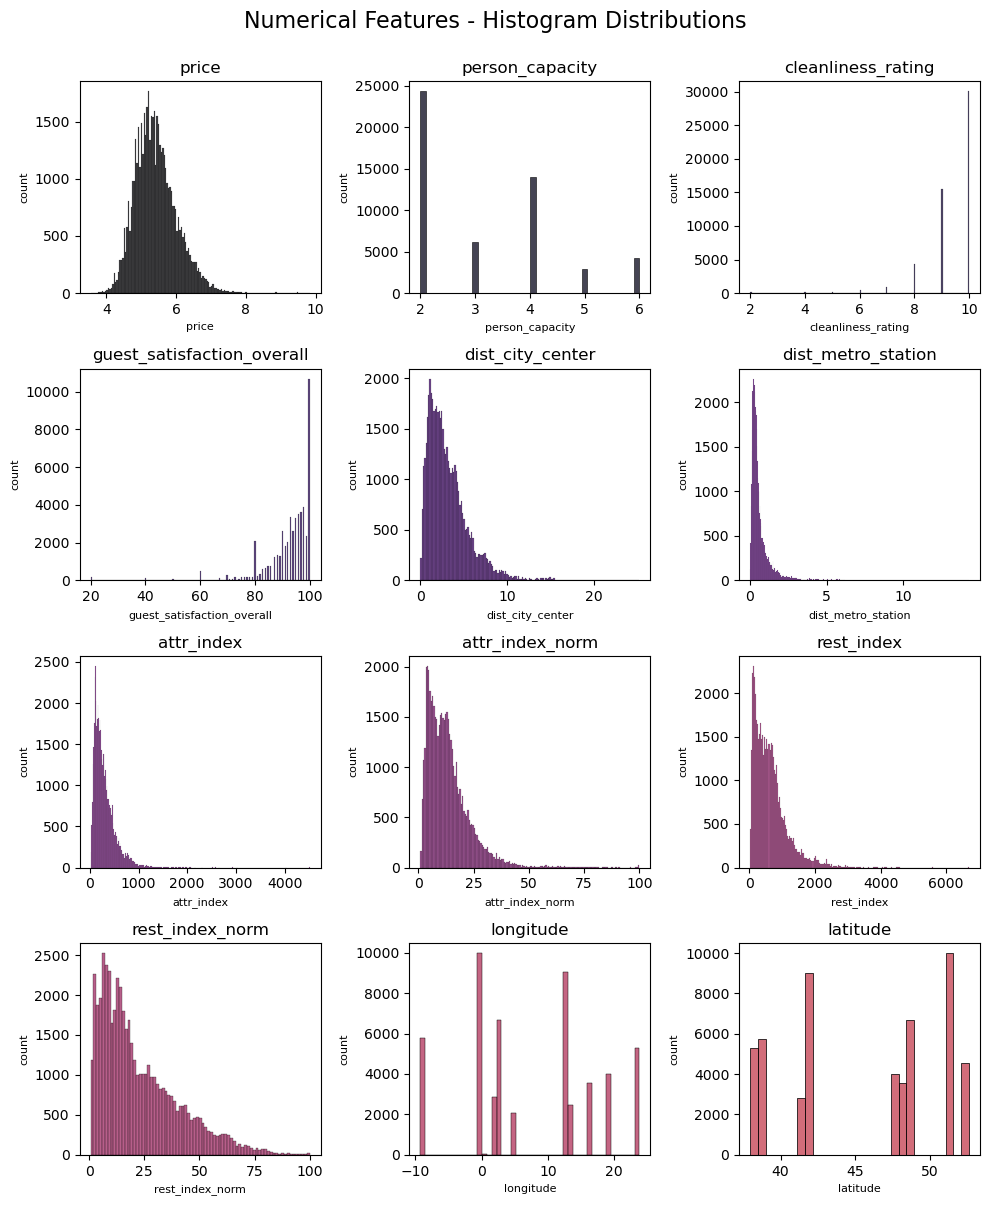

In [17]:
# Histogram Distributions - Numerical Features
fig, axes, cmap = init_subplots(4, 3, (10,12), df) # init subplot

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]                               # get subplot idx
    color, _ = color_palette(cmap, idx, df, col) # init color
    sns.histplot(df, x=col, ax=ax, color=color)
    ax.set_title(col)
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("count", fontsize=8)

fig.text(0.5, 0.985, "Numerical Features - Histogram Distributions", fontsize=16, ha="center")
show_plots(df, fig, axes, [0, 0, 1, 0.97]) # display plots

**Observations - Numerical**

Based on the *histogram* distributions, we can see that...

- ***Price:*** Heavily skewed to the right, indicating that most listing have lower prices with some high-priced outliers.

- ***Guest Satisfaction:*** Skewed toward high satisfaction, with many ratings clustered around 100.

- ***Distance:*** Most listings are within 5km of the city center.

- ***Restaurants & Attractions:*** Heavily skewed to the right, indicating that most listings are near fewer restaurants/attractions, while a small number are near a high density of them.

- ***Location:*** Based on *longitude* and *latitude*, listings are clearly concentrated in specific geographic regions as seen by the clustering.

Now let's plot the distributions for *categorical features* in the dataset using *countplots*.

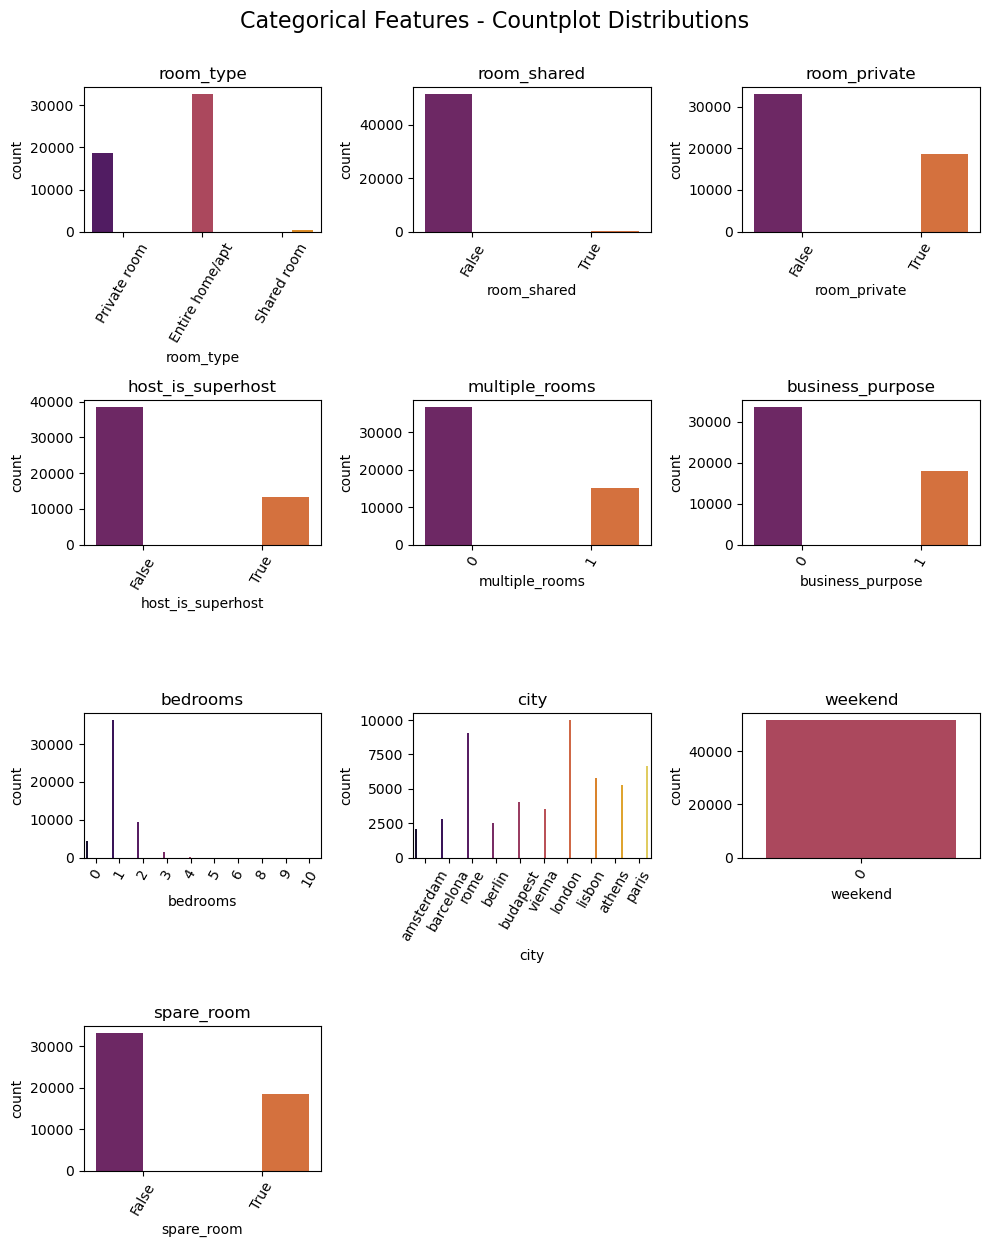

In [18]:
# Countplot Distributions - Categorical Features
fig, axes, cmap = init_subplots(4, 3, (10,12), df) # init subplot

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]                                             # get subplot idx
    _, palette = color_palette(cmap, num_categorical, df, col) # init palette
    sns.countplot(df, x=col, ax=ax, palette=palette, hue=col)
    ax.set_title(col)
    ax.legend_.remove()
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="center")

for ax in axes[len(categorical_cols):]: ax.remove()
fig.text(0.5, 1.02, "Categorical Features - Countplot Distributions", fontsize=16, ha="center")
show_plots(df, fig, axes, None) # display plots

**Observations - Categorical**

Based on the *countplot* distributions, we can see that...

- ***Room Types:*** "Entire home/apt" is the majority of the listings, followed by "Private room" then "Shared room".

- ***Room Features:*** A significant number of listings have private rooms where its capacity is around 2-4 people.

- ***Superhost Status:*** Majority of hosts are not superhosts, suggesting that becoming a superhost is rare.

- ***City Distribution:*** Majority of listsings in London, followed by Rome and Paris. There are significant variations in the number of listings across the other cities.

- ***Weekend:*** Most listings are not flagged as "weekend", which might indicate mostly weekday stays or a lack of weekend-specific data.

### ii) Correlation Analysis

Now let's conduct a correlation analysis to look at the relationships between price and each feature.

First, let's plot the correlation distributions for *numerical features* in the dataset using *scatterplots*.

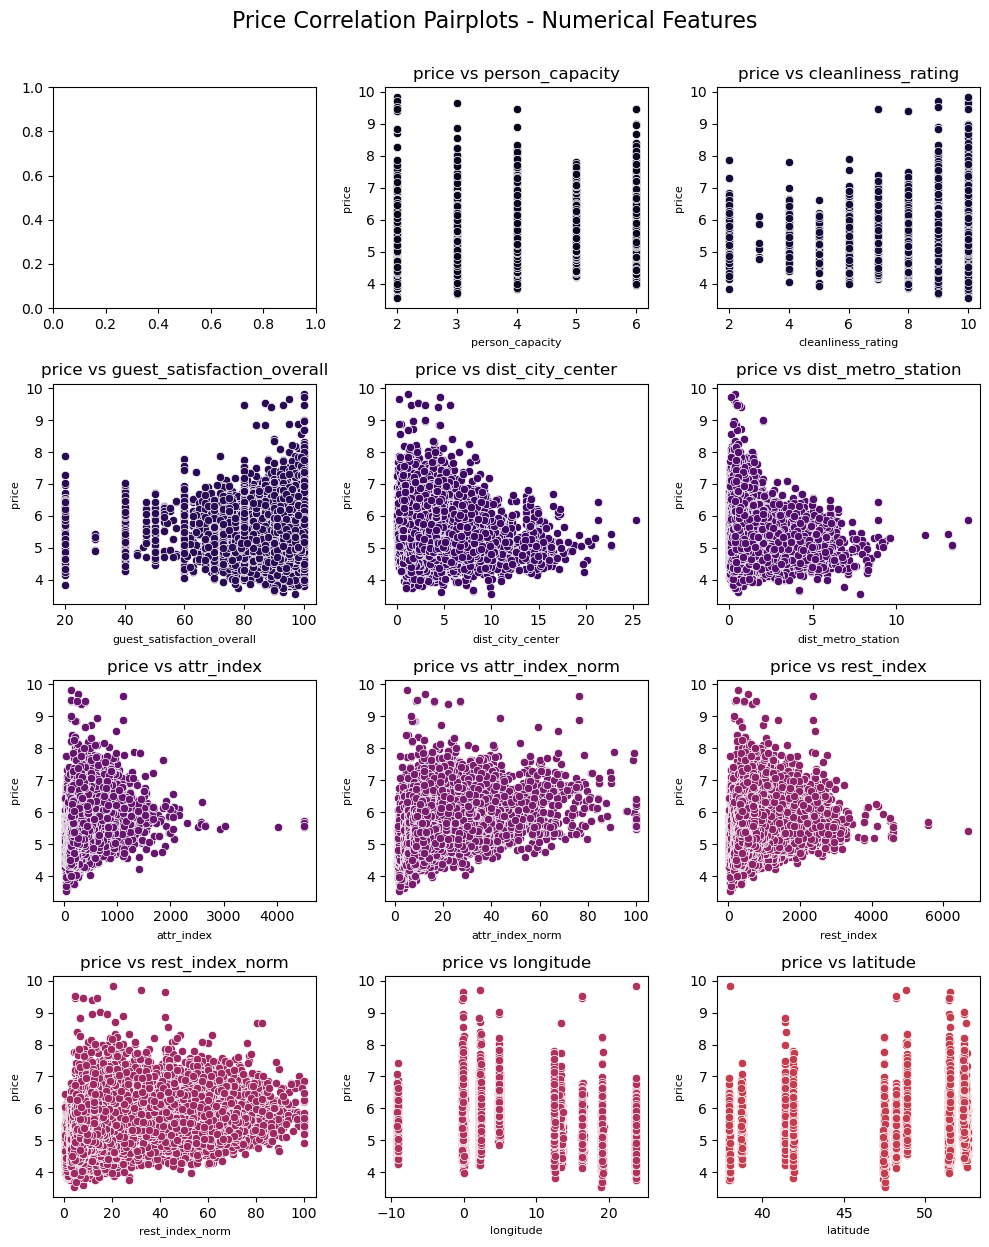

In [19]:
# Scatterplot Distributions - Numerical Features
fig, axes, cmap = init_subplots(4, 3, (10, 12), df) # init subplots
numerical_cols, _, _ = separate_features(df)        # separate types

for idx, col in enumerate(numerical_cols):
    if col == "price":  # skip price column
        continue

    else:
        ax = axes[idx]  # Get subplot
        color, _ = color_palette(cmap, idx, df, col)  # Init color
        sns.scatterplot(x=df[col], y=df["price"], ax=ax, color=color)
        ax.set_title(f"price vs {col}")
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel("price", fontsize=8)

fig.text(0.5, 1.02, "Price Correlation Pairplots - Numerical Features", fontsize=16, ha="center")
show_plots(df, fig, axes, None)  # Display numerical pairplots

**Observations - Numerical:**

In relation to *price*, the following numerical features are...

- ***person_capacity:*** positively correlated

- ***guest_satisfaction_overall:*** positively correlated

- ***attr_index:*** positively correlated

- ***rest_index:*** positively correlated

- ***dist_city_center:*** negatively correlated

- ***location:*** not significantly correlated

Now let's plot the correlation distributions for *categorical features* in the dataset using *boxplots*.

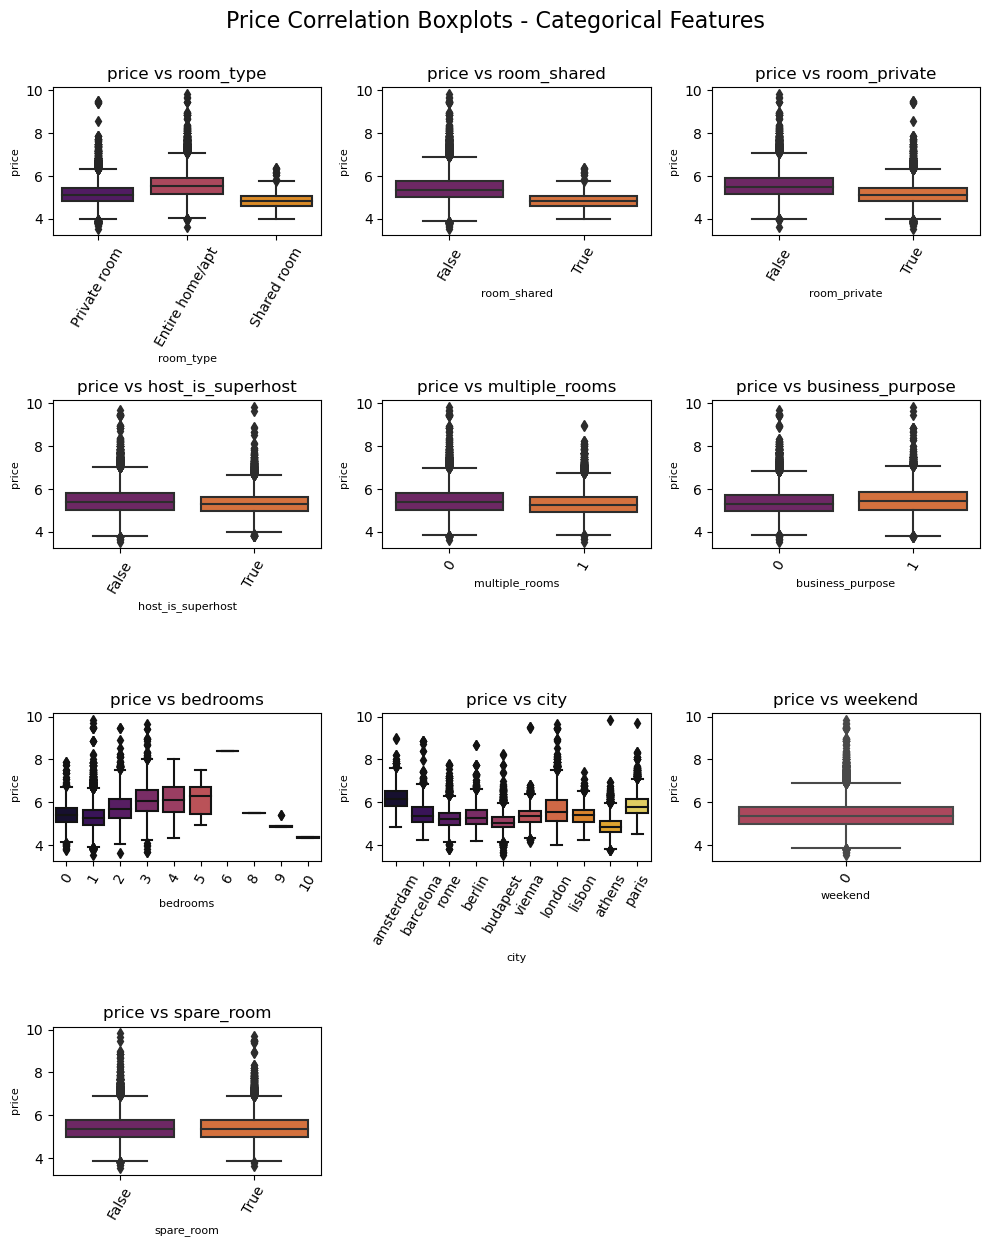

In [20]:
# Boxplot Distributions - Categorical Features
fig, axes, cmap = init_subplots(4, 3, (10, 12), df) # init subplots
_, categorical_cols, _ = separate_features(df)      # separate types

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]  # Get subplot
    _, palette = color_palette(cmap, idx, df, col)  # init palette
    sns.boxplot(x=df[col], y=df["price"], ax=ax, palette=palette)
    ax.set_title(f"price vs {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="center")
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("price", fontsize=8)

for ax in axes[len(categorical_cols):]: ax.remove()
fig.text(0.5, 1.02, "Price Correlation Boxplots - Categorical Features", fontsize=16, ha="center")
show_plots(df, fig, axes, None)  # display plots

**Observations - Categorical:**

In relation to *price*, the following categorical features are...

- ***room_type:*** positively correlated

- ***host_is_superhost:*** positively correlated but weak

- ***multiple_rooms:*** positively correlated

- ***business_purpose:*** positively correlated

- ***city:*** not linearly correlated

- ***weekend:*** not correlated

## Method 1 - Principal Component Analysis (PCA)

For our first method, let's use *PCA Clustering*.

### i) Train, Test Split

First, let's *train, test split* the dataset to prepare it for modeling. Note that our test size is 0.17647 because this is 15% of the original dataset.


In [21]:
# Train, Test, Split
X = df.drop(columns = ['price']) # drop "price" col
y = df['price']

# split into train, test, validation sets
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.15, random_state = 1234, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.17647, random_state = 1234, shuffle = True)

### ii) Standardize Data

Second, let's standardize the data to improve our PCA model performance.

Note: We can remove the *room_type* column because we already have the one-hot encoded *room_shared* and *room_private* features.

In [22]:
# Get Data
X_df = X_train
X_df = X_df.drop(columns = ['room_type'])
X_df = pd.get_dummies(X_df)
X_df.head()

,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,...,city_amsterdam,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna
4521,False,True,2.0,False,0,0,9.0,100.0,1,6.075903,...,0,0,0,0,0,0,1,0,0,0
290,False,False,5.0,False,0,1,9.0,87.0,2,4.369525,...,0,0,0,0,0,0,0,0,1,0
870,False,False,2.0,False,0,0,10.0,98.0,1,3.091255,...,1,0,0,0,0,0,0,0,0,0
1421,False,False,4.0,True,0,1,10.0,97.0,1,0.039814,...,0,0,0,0,0,0,0,0,0,1
2336,False,False,6.0,False,1,0,10.0,93.0,2,1.663066,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# Standardize Data
scaler = preprocessing.StandardScaler()
scaled_X_train_df = scaler.fit_transform(X_df)

# standardize X_test and X_valid
scaled_X_valid_df = X_valid.drop(columns = ['room_type'])
scaled_X_valid_df = pd.get_dummies(scaled_X_valid_df)
scaled_X_valid_df = scaler.transform(scaled_X_valid_df)

scaled_X_test_df = X_test.drop(columns = ['room_type'])
scaled_X_test_df = pd.get_dummies(scaled_X_test_df)
scaled_X_test_df = scaler.transform(scaled_X_test_df)

### iii) Conduct PCA

In [24]:
# Compute Explained Variance
pca = decomposition.PCA().fit(scaled_X_train_df)                  # perform PCA
explained_var = round(sum(pca.explained_variance_ratio_[:13]), 4) # compute explained variance
print(f"Explained Variance = {explained_var}")

Explained Variance = 0.8217


***Observation:*** Based on the explained variance computer above, the first 13 principal components explain around 82% of the variability in the data. This suggests that, after PCA, the reduced dimensions are still highly representative of the original data.

Let's transform the *training* data.

Note: We only want to keep the first 13 principal components because our model is able to explain around 82% of the variance in the data.

In [25]:
# Transformation - Training Data
scaled_X_train_df = pca.transform(scaled_X_train_df)
scaled_X_train_df = pd.DataFrame(scaled_X_train_df)
scaled_X_train_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_train_df = scaled_X_train_df.iloc[:,0:13]
scaled_X_train_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-1.709176,3.173317,-0.301611,-0.678889,0.030997,0.878203,0.393195,-1.213603,-0.102006,0.148311,0.251185,-0.772555,-0.577342
1,0.040465,-1.365481,1.474920,-0.071694,2.222342,1.428033,0.946349,-0.047040,1.218082,0.107953,-0.461000,0.483944,0.117296
2,-1.054098,1.055490,-1.772049,0.823219,-1.582016,0.627959,0.585880,0.013659,-0.599196,1.254632,-2.504692,-1.401615,3.171269
3,3.390135,-0.304462,-2.026787,1.115215,1.848963,-0.576302,-3.345517,-1.893682,-1.055377,-1.275223,-2.025303,1.994374,0.685182
4,-2.139397,-3.517429,0.391626,0.222295,1.315597,0.208061,-0.303040,1.024380,-2.046145,0.176924,1.717304,0.059604,0.730667


Let's take a look at the *eigenvectors* in the dataset.

***Eigenvectors:***
- Determine how much each original feature contributes (weighs) to a principal component
- Help interpret principal components by showing the relationship between the original and transformed components

In [26]:
# Get Eigenvectors
eigenvectors = pd.DataFrame(pca.components_, columns =['PC_' + str(i) for i in range(1, 30)])
eigenvectors = eigenvectors.iloc[:, 0:13]
eigenvectors.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-0.002826,-0.034363,0.019286,-0.063111,-0.024458,0.138009,-0.068331,-0.091645,-0.025010,-0.278348,-0.193594,0.447336,0.360298
1,0.011024,0.252441,-0.244522,-0.165813,-0.012059,-0.055368,-0.153182,-0.134768,-0.131195,0.319853,0.154750,-0.001980,0.211381
2,0.046723,0.057482,0.055780,-0.192755,-0.043450,0.340793,-0.287408,-0.349518,0.060099,0.005574,0.052092,-0.103884,-0.186327
3,0.099275,-0.354370,0.240826,-0.174837,-0.363034,0.173597,-0.231017,-0.203725,0.079405,-0.119526,-0.207336,-0.153014,0.091759
4,-0.017877,-0.092116,0.252894,-0.069059,0.064365,0.138582,-0.243635,-0.246977,0.171422,0.139802,0.120903,0.153316,0.119641


Now let's visualize the eigenvectors for each principal component. More specifically, let's look at how much of each feature contributed to the corresponding principal component.

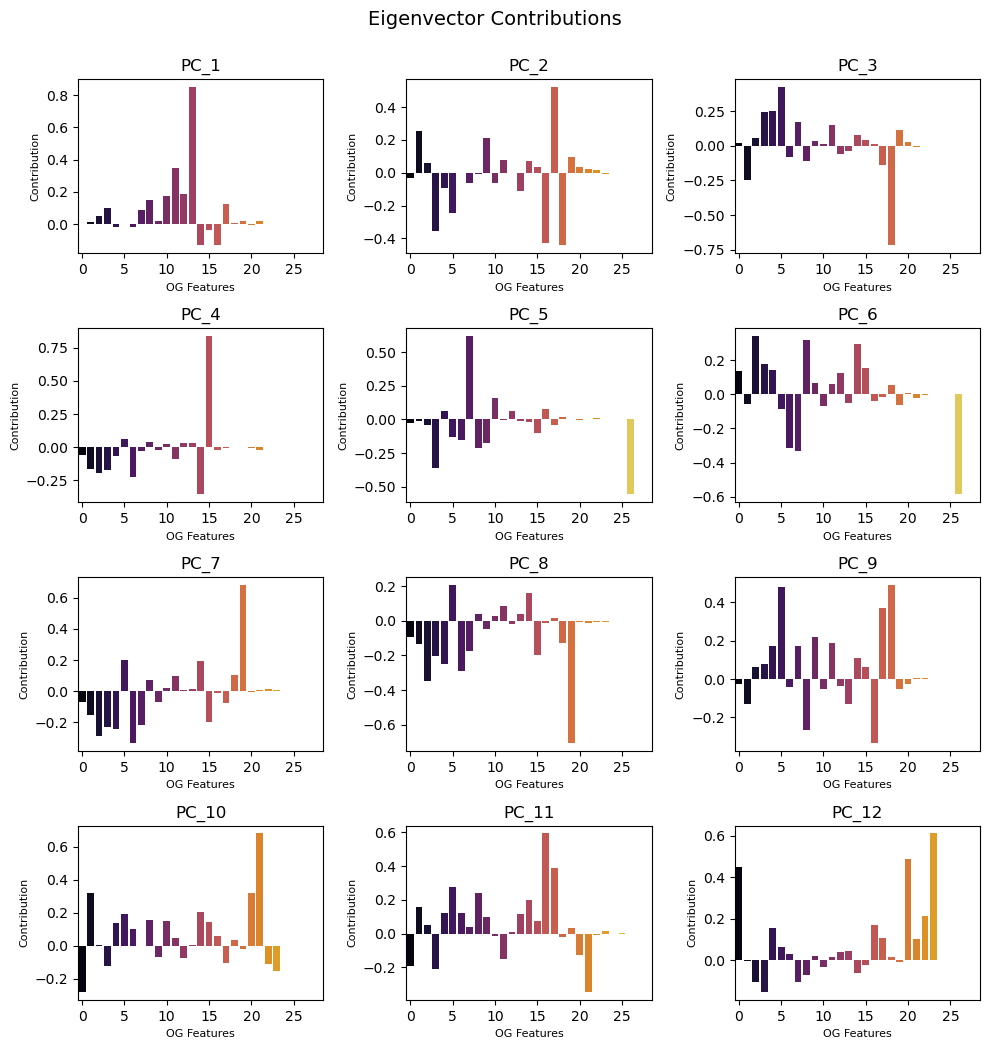

In [27]:
# Eigenvector Barplots
fig, axes, cmap = init_subplots(8, 3, (10,20), df) # init plots

for idx, PC in enumerate(eigenvectors.columns):
    ax = axes[idx] # get subplot idx
    palette = sns.color_palette("inferno", n_colors=len(eigenvectors.index))

    sns.barplot(x=eigenvectors.index, y=eigenvectors[PC], ax=ax, palette=palette)
    ax.set_title(PC)
    ax.set_xlabel("OG Features", fontsize=8)
    ax.set_ylabel("Contribution", fontsize=8)

    # setup x-ticks parameters
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::5]) # skip every 5 ticks
    ax.tick_params(axis='x')

fig.suptitle("Eigenvector Contributions", fontsize=14, y=1)
show_plots(eigenvectors, fig, axes, None) # display plots

***Observations:*** Based on these principal component barplots, many of the components have a single feature that has a significant, positive contribution. This suggests that those features contribute the most in terms of explaining the variance captured in that given principal component.

Now let's transform the *validation* and *test* data too so we can visualize the PCA results.

In [28]:
# Transformation - Valid Data
scaled_X_valid_df = pca.transform(scaled_X_valid_df)
scaled_X_valid_df = pd.DataFrame(scaled_X_valid_df)
scaled_X_valid_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_valid_df = scaled_X_valid_df.iloc[:,0:13]
scaled_X_valid_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-0.115205,-0.208911,0.095240,-2.980467,0.737144,-0.660679,1.082446,0.931257,0.830086,-0.471769,-0.029525,-0.009886,0.192969
1,-1.794654,-0.307014,1.805416,0.101681,-2.716635,2.137055,0.726826,-0.247013,0.177682,-0.365854,-0.007786,-0.150063,-0.834266
2,0.392566,2.132829,0.419610,0.300614,0.402313,-0.571404,-1.660304,-1.797039,0.636687,-0.856133,0.494977,-0.609448,0.201958
3,-1.863624,-0.491025,-1.145089,-1.188793,-0.222995,-1.977980,-1.692958,0.653916,-0.787514,-2.148527,-1.944209,1.445009,0.208303
4,0.342334,1.380505,-0.888497,1.168522,-0.077026,-1.530997,-1.280519,0.039309,2.026421,2.590717,0.842710,2.754276,0.677151


In [29]:
# Transformation - Test Data
scaled_X_test_df = pca.transform(scaled_X_test_df)
scaled_X_test_df = pd.DataFrame(scaled_X_test_df)
scaled_X_test_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_test_df = scaled_X_test_df.iloc[:,0:13]
scaled_X_test_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,1.236444,1.599645,-0.874423,-0.644473,0.637554,0.460280,-1.998393,0.385484,-1.302170,-0.859287,0.852106,-0.252504,0.086236
1,-0.981339,-1.733445,-0.587003,-0.318053,0.659318,2.180394,1.628737,-0.353031,0.165613,-0.056706,-0.486234,0.561211,-0.543538
2,1.474553,-1.880751,-1.368241,1.748467,0.287675,-0.760788,-2.174331,0.665459,1.895781,1.024757,-0.669662,-1.562847,-1.346920
3,-0.272389,-2.156614,-1.887447,2.404077,0.545919,2.065716,-0.602423,1.338597,-0.207662,1.614169,-0.938654,-0.649187,-2.346019
4,1.506163,-0.088381,2.996888,-0.129377,-1.678814,-0.494556,0.747634,2.379977,-0.389507,-0.413362,0.210451,-0.719072,0.010682


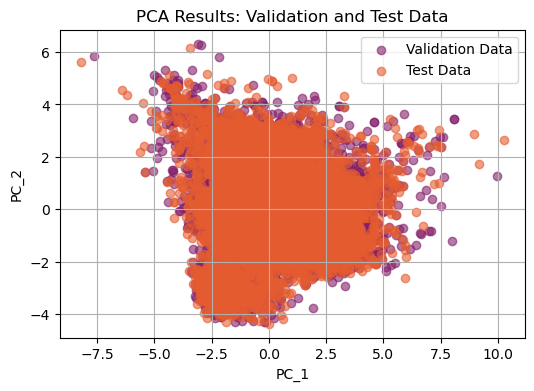

In [30]:
# PCA Scatterplot
plt.figure(figsize=(6, 4))
plt.scatter(scaled_X_valid_df["PC_1"], scaled_X_valid_df["PC_2"], alpha=0.6, label="Validation Data", color="#84206b")
plt.scatter(scaled_X_test_df["PC_1"], scaled_X_test_df["PC_2"], alpha=0.6, label="Test Data", color="#e55c30")
plt.title("PCA Results: Validation and Test Data")
plt.legend()
plt.xlabel("PC_1")
plt.ylabel("PC_2")
plt.grid(True)
plt.show()

**Observations**

Based on this combined scatterplot, there's a significant overlap between *validation* and *test* datasets in the PCA space. This indicates that the two datasets share similar distributions and patterns. And this suggests...

- ***Consistency:*** The feature representation across these datasets is consistent

- ***Simplicity:*** Without distinct clustering and separation, the dataset doesn't show strong non-linear patterns

- ***Generalizability:*** Components can effectively represent unseen data (validation and test sets)

## Method II - Multi-Linear Regression (MLR)

Based on the *PCA*, the identified principal components capture the variance in the dataset while reducing multicolinearity among features.

For our second method, let's use *Multi-Linear Regression (MLR)* on the reduced feature set to build a model for predicting Airbnb prices while mitigating overfitting.


$$y' = b + w_1x_1 + w_2x_2 + ... + w_nx_n$$

Residuals: $e = y_{actual} - y_{predicted}$

Minimize --> find line of best fit: $Loss = e_1^2 + e_2^2 + ... + e_n^2$

### i) Compute Parameters

First, let's compute the *MSE* and *gradient* parameters we will use for modeling.

In [31]:
# Compute Parameters
def mse(coef, x, y):
    return np.mean((np.dot(x, coef) - y) ** 2) / 2

def gradients(coef, x, y):
    return np.mean(x.T * (np.dot(x, coef) - y), axis=1)

In [32]:
# Multi-Linear Regression
def MLR(coef, x, y, lr=0.01, b1=0.9, b2=0.999, epsilon=1e-8, tol=1e-4, max_iter=1000):
    prev_error = float("inf")
    m_coef = np.zeros(coef.shape)
    v_coef = np.zeros(coef.shape)
    t = 0

    while True:
        error = mse(coef, x, y)
        if abs(error - prev_error) <= epsilon: break

        prev_error = error
        grad = gradients(coef, x, y)
        t += 1

        # Adam optimizer updates
        m_coef = b1 * m_coef + (1 - b1) * grad
        v_coef = b2 * v_coef + (1 - b2) * (grad ** 2)
        m_hat = m_coef / (1 - b1 ** t)
        v_hat = v_coef / (1 - b2 ** t)
        coef -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

        if t > max_iter: break # max iters reached

    return coef

### ii) Conduct MLR

Second, let's intiialize our variables then perform our *MLR* model.

In [33]:
# Initialize Variables (X_train)
X_train = pd.get_dummies(X_train, columns=["room_type", "city"], drop_first=True)
X_train_np = X_train.values.astype(float)
X_train_np = np.hstack((X_train_np, np.ones((X_train_np.shape[0], 1)))) # add bias
y_train_np = y_train.values.astype(float)

coefficients = np.zeros(X_train_np.shape[1]) # init coefficients

In [34]:
# Run MLR Model
final_coefficients = MLR(coefficients, X_train_np, y_train_np)
print(f"Final Coefficients:\n{np.round(final_coefficients, 3)}")

Final Coefficients:
[-0.409 -0.208  0.091  0.013  0.088  0.156  0.033  0.002  0.148 -0.018
 -0.015  0.     0.008  0.     0.001 -0.012  0.097  0.     0.045 -0.208
 -0.409  0.221  0.476 -0.507 -0.627  0.31  -0.383 -0.121  0.08  -0.234
  0.101]


### iii) Evaluate MLR Model

Finally, let's evaluate our *MLR* model by using our *test* data.

In [35]:
# Initialize Variables (X_test)
X_test = pd.get_dummies(X_test, columns=["room_type", "city"], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_test_np = X_test.values.astype(float)
X_test_np = np.hstack((X_test_np, np.ones((X_test_np.shape[0], 1)))) # add bias

y_pred = np.dot(X_test_np, final_coefficients) # predict on test data

In [36]:
# Evaluate MLR Model
mse_test = np.mean((y_test.values - y_pred) ** 2)  # Mean Squared Error
r_squared = 1 - (np.sum((y_test.values - y_pred) ** 2) / np.sum((y_test.values - np.mean(y_test.values)) ** 2))

print(f"Test MSE: {mse_test:.3f}")
print(f"Test R²:  {r_squared:.3f}")

Test MSE: 0.121
Test R²:  0.655


**Observations**

- ***MSE:*** An MSE of 0.121 suggests that our model ??

- ***R^2:*** An $R^2$ of 0.655 suggests that our model indicates a moderately strong relationship between the Airbnb dataset features and our target variable *price*. However, this also means that around 35% of the variability is not explained, which is likely due to missing features, randomness, and noise in our data.

## Analysis

### i) Numerical Comparison

First, let's compare the *actual* vs *predicted* price values we computed as a dataset.

In [37]:
# Compare Actual vs Predicted Prices
y_scaler = preprocessing.StandardScaler()
y_scaler.fit(y_train.values.reshape(-1, 1)) # fit on y_train data

# map city columns
city_columns = [col for col in X_test.columns if col.startswith("city_")] # find city cols
city_map = {col: col.split("_")[1] for col in city_columns}               # map col to city names
X_test["city"] = X_test[city_columns].idxmax(axis=1).map(city_map)        # find city name for each row

# create comparison_df
comparison_df = pd.DataFrame({
    "City" : X_test["city"],        # get city
    "Actual Price" : y_test.values, # actual prices
    "Predicted Price" : y_pred      # predicted prices
})

# inverse transformations on prices
comparison_df["Actual Price"] = y_scaler.inverse_transform(comparison_df[["Actual Price"]].values)
comparison_df["Actual Price"] = np.exp(comparison_df["Actual Price"])

comparison_df["Predicted Price"] = y_scaler.inverse_transform(comparison_df[["Predicted Price"]].values)
comparison_df["Predicted Price"] = np.exp(comparison_df["Predicted Price"])

# group by city and compute avg prices
comparison_grouped = comparison_df.groupby("City").mean()
comparison_grouped = comparison_grouped.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)
comparison_grouped.reset_index(inplace=True)

print("  Actual vs Predicted Airbnb Prices ($)")
comparison_sorted = comparison_grouped.sort_values(by="Actual Price", ascending=True) # sort prices in ascending order
comparison_sorted

  Actual vs Predicted Airbnb Prices ($)


,City,Actual Price,Predicted Price
3,budapest,"4,860.07","4,767.73"
7,rome,"5,256.55","5,246.65"
4,lisbon,"5,755.33","5,706.46"
8,vienna,"5,764.98","5,675.59"
0,athens,"5,921.26","5,651.89"
2,berlin,"5,927.49","5,663.64"
1,barcelona,"6,261.63","5,985.84"
5,london,"7,191.25","6,812.08"
6,paris,"7,634.56","7,461.81"


**Numerical Analysis**

In the table above are the average *average* and *predicted* prices of Airbnb listings per European city.

- ***Pros:*** The *predicted* prices align closely with the *actual* prices across all cities, indicating that our model performs well overall.

- ***Cons:*** There are slight variations, like in *London* and *Paris*, where the *predicted* values slightly underestimate the *actual* prices.

### ii) Graphical Comparison

Second, let's create several plots to visually analyze how our *MLR* model performed in predicting Airbnb prices.

Let's look at a *scatterplot*.

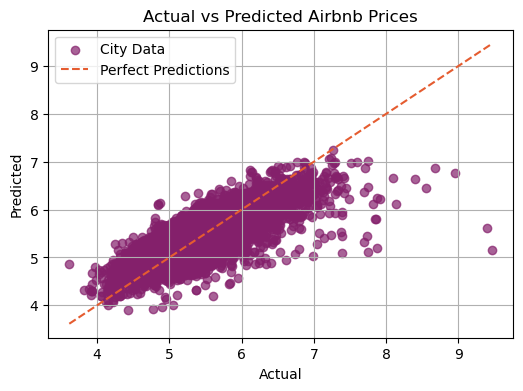

In [38]:
# Scatterplot
min_price = min(y_test.min(), y_pred.min()) # compute min
max_price = max(y_test.max(), y_pred.max()) # compute max

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color="#84206b", label="City Data")
plt.plot([min_price, max_price], [min_price, max_price], "r--", color="#e55c30", label="Perfect Predictions")
plt.title("Actual vs Predicted Airbnb Prices")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid()
plt.legend()
plt.show()

**Graphical Analysis - Scatterplot**

Based on our *scatterplot* of actual vs predicted prices, our model...

- ***Performance:*** performs reasonably well given many predictions align closely with the *perfect predictions* line

- ***Errors:*** contains some outliers that indicate areas where our model's predictions deviate more significantly from *actual* prices

Now let's look at a *barplot*.

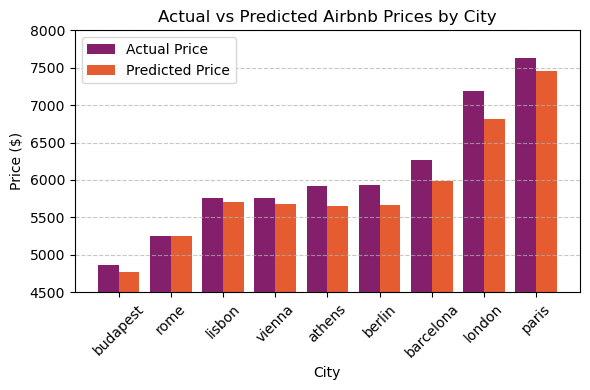

In [39]:
# Barcharts
comparison_sorted["Actual Price"] = comparison_sorted["Actual Price"].replace(',', '', regex=True).astype(float)
comparison_sorted["Predicted Price"] = comparison_sorted["Predicted Price"].replace(',', '', regex=True).astype(float)

# extract sorted values
cities = comparison_sorted["City"].values                      # city names
actual_prices = comparison_sorted["Actual Price"].values       # actual prices
predicted_prices = comparison_sorted["Predicted Price"].values # predicted prices
position = np.arange(len(cities))                              # x-axis position

# combine actual/predicted prices
all_prices = np.concatenate((actual_prices, predicted_prices))
min_price = np.floor(all_prices.min() / 500) * 500  # round to neareast 500
max_price = np.ceil(all_prices.max() / 500) * 500

# plot
plt.figure(figsize=(6, 4))
plt.bar(position - 0.2, actual_prices, width=0.4, label="Actual Price", color="#84206b")
plt.bar(position + 0.2, predicted_prices, width=0.4, label="Predicted Price", color="#e55c30")
plt.title("Actual vs Predicted Airbnb Prices by City")
plt.xlabel("City")
plt.ylabel("Price ($)")
plt.xticks(position, cities, rotation=45)     # city names
plt.ylim(min_price, max_price)                # ensure y-axis range matches data
plt.grid(axis="y", linestyle="--", alpha=0.7) # grid for y-axis only
plt.tight_layout()
plt.legend()
plt.show()

**Graphical Analysis - Barplot**

Based on our *barplot* of actual vs predicted prices by city, our model...

- ***Predictions:*** The *actual* Airbnb prices tend to be higher than our *predicted* prices for all cities.

- ***Highest Prices:*** Paris has the highest Airbnb prices, followed by London and Barcelona.

- ***Lowest Prices:*** Budapest has the lowest Airbnb prices, followed by Rome then Lisbon.

## Conclusion

We conclude that our *Multi-Linear Regression* model...

- Demonstrates a reasonable ability to predict Airbnb prices across various European cities.

- Contains certain city-specific factors may require additional consideration to enhance prediction accuracy.

- Provides insights that can help property owners and managers develop data-driven pricing strategies that reflect both competitive standards and localized dynamics.

## Method 3 - Deep Learning Neural Network (PCA)


### i) Preprocess for Neural Network

- Encode our categorical variables and scale the numerical variables
- Engage our train test split


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Seperate target and feature variables
X = df.drop('price', axis=1)
y = df['price']

# Encode categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Scale numerical columns
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X_scaled[numerical_columns])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.17647, random_state=42)

### ii) Define and Train Model

- Using the keras tuner for hyperparemeters we were able to create a dense neural network with optimisation 
- We train our model preventing early stopping


In [102]:
# Define the model with tuned hyperparameters
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(288, activation='relu', input_shape=[input_shape]),
        layers.Dense(320, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.00015)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Train
input_shape = X_train.shape[1]
model = build_model(input_shape)
history = model.fit(
    X_train, y_train,
    validation_split=0.17647,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 5.0561 - val_loss: 0.1479
Epoch 2/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.1298 - val_loss: 0.1083
Epoch 3/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.1133 - val_loss: 0.1062
Epoch 4/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.1031 - val_loss: 0.1078
Epoch 5/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.1014 - val_loss: 0.1053
Epoch 6/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 0.1001 - val_loss: 0.1012
Epoch 7/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.0983 - val_loss: 0.1045
Epoch 8/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.1004 - val_loss: 0.0995
Epoch 9/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.0958 - val_loss: 0.0994
Epoch 10/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - loss: 0.0954 - val_loss: 0.0982
Epoch 11/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 0.0944 - val_loss: 0.09

### iii) Graph and plot metrics

- Run an evaluation of the model and print RMSE
- Plot our validation loss and training loss over time


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Root Mean Squared Error: 0.3101481483961777
Mean Squared Error: 0.09619187395357748


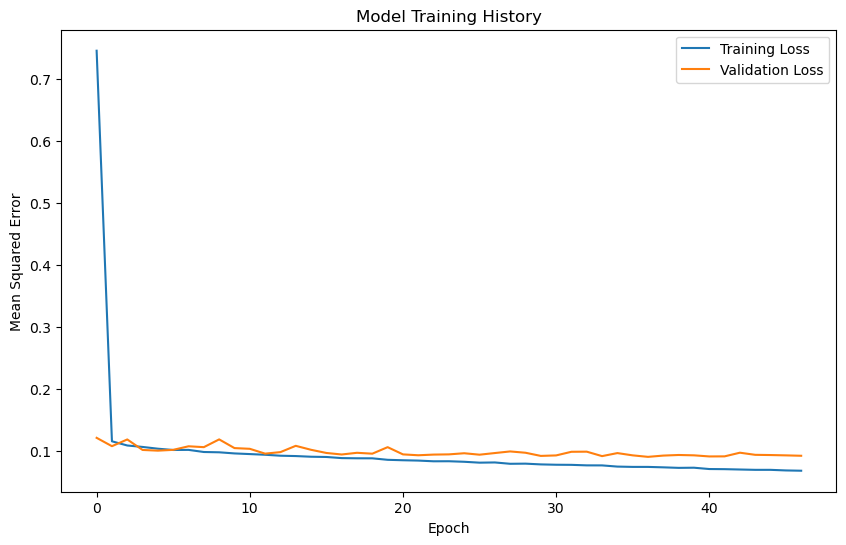

In [101]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Squared Error: {mse}")


# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Model Training History')
plt.legend()
plt.show()

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


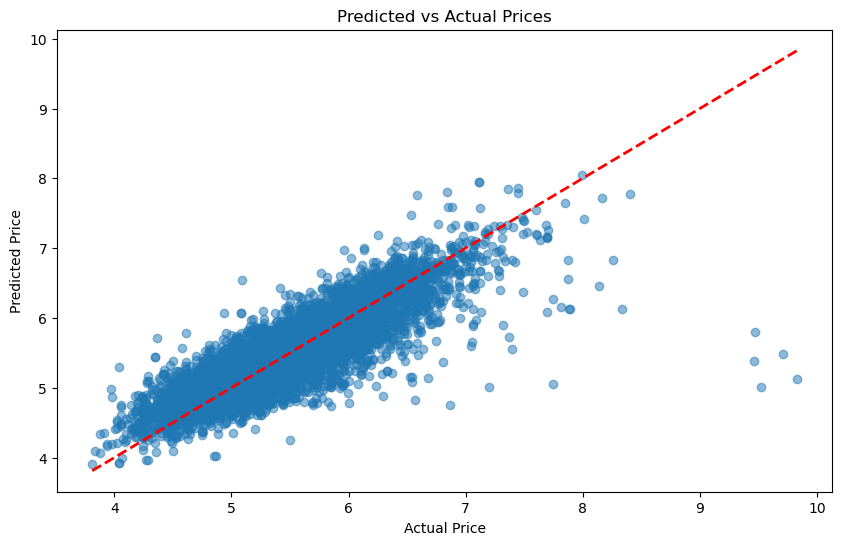

In [98]:
#Plot our Predicted vs Actual prices
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.show()

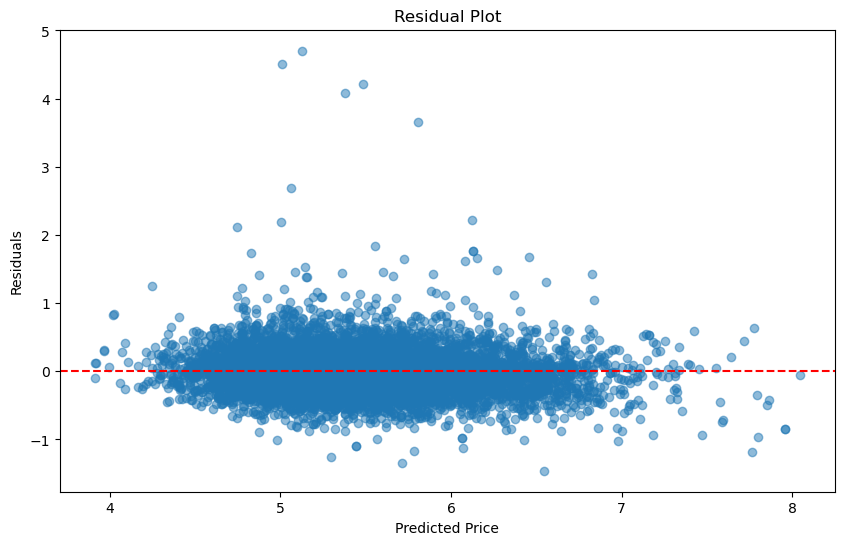

In [99]:
# Plot our residuals
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def adjusted_r2_score(y_true, y_pred, n, p):
    r2 = 1 - (((1 - r2_score(y_true, y_pred)) * (n - 1)) / (n - p - 1))
    return r2

# Flatten y_test and y_pred to ensure they are 1-dimensional
y_test = y_test.ravel()  # or use y_test.flatten()
y_pred = y_pred.ravel()  # or use y_pred.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adj_r2 = adjusted_r2_score(y_test, y_pred, n, p)

# Calculate bias and variance
bias = np.mean(y_pred - y_test)
variance = np.mean((y_pred - np.mean(y_pred))**2)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Adjusted R-squared Score: {adj_r2:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")




Mean Absolute Error: 0.22
Root Mean Squared Error: 0.31
Adjusted R-squared Score: 0.7248
Bias: 0.0131
Variance: 0.2847


In [64]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                 activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                                     activation='relu'))
    
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='airbnb_price_prediction')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers: {best_hps.get('num_layers')}
The optimal learning rate for the optimizer is: {best_hps.get('learning_rate'):.4f}
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Trial 254 Complete [00h 00m 21s]
val_loss: 0.09643585234880447

Best val_loss So Far: 0.0865277424454689
Total elapsed time: 01h 09m 50s

The hyperparameter search is complete. The optimal number of layers: 4
The optimal learning rate for the optimizer is: 0.0007

Epoch 1/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4867 - val_loss: 0.1075
Epoch 2/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1222 - val_loss: 0.1109
Epoch 3/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1207 - val_loss: 0.1062
Epoch 4/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1222 - val_loss: 0.1266
Epoch 5/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1179 - val_loss: 0.1350
Epoch 6/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1108 - val_loss: 0.1061
Epoch 7/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1088 - val_loss: 0.1361
Epoch 8/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1082 - val_loss: 0.0968
Epoch 9/100
1065/1065 ━

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0468 - val_loss: 0.0868
Epoch 66/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0453 - val_loss: 0.0872
Epoch 67/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0480 - val_loss: 0.0886
Epoch 68/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0465 - val_loss: 0.0935
Epoch 69/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0442 - val_loss: 0.0859
Epoch 70/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0445 - val_loss: 0.0926
Epoch 71/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0438 - val_loss: 0.0867
Epoch 72/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0422 - val_loss: 0.0850
Epoch 73/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0423 - val_loss: 0.0895
Epoch 74/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0423 - val_loss: 0.0926
Epoch 75/100
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0436 - val_loss: 0.0866
Epoch 76/100
1065/1065 

## Conclusion

We conclude that our *Neural Network* model...

- Demonstrates a reasonable ability to predict Airbnb prices across various European cities based on the accuracy and R^2

- May be neccessary to further tune parameters for optimal prediction

- Potentially overfits the data due to the validation loss converging with training loss and then begins to increase. Could be a result of containing such a large sum of data

# NOTES!!

Using original features: X_train, X_valid, X_test

Using PCA (dimensionality reduced features): scaled_X_train_df, scaled_X_valid_df, scaled_X_test_df

USE THE SAME y_train, y_valid, y_test FOR BOTH

We set the log(price) as the target variable because the price column is very skewed and there does not seem to be strong linear relationships between price and the other variables.

At the top, there's two cells to extract/load the dataset: first one if you're using Colab and second if you're using VSCode. So just comment out the one you aren't using and it should run.

Now we just need to do the MLR and a final analysis (with some plots maybe).